In [1]:
%load_ext autoreload 
%autoreload 2
import os
import numpy as np

from surforama.io.star import load_points_layer_data_from_star_file
from surforama.io.mesh import read_obj_file

### Define data paths

In [2]:
pixel_size = 13.68 # pixel size in Angstrom

example_usecase_dir = "../../example_usecase/"
star_files = [
    "M2.star",
    "M3b.star",
    "M3c.star",
    "M4b.star",
    "M5c.star"
]

mesh_files = [
    "Tomo1L1_M2.obj",
    "Tomo1L1_M3b.obj",
    "Tomo1L1_M3c.obj",
    "Tomo1L1_M4b.obj",
    "Tomo1L1_M5c.obj",
]

tomo_file = "Tomo1L1_bin4.rec"

star_files = [os.path.join(example_usecase_dir, f) for f in star_files]
mesh_files = [os.path.join(example_usecase_dir, f) for f in mesh_files]
tomo_file = os.path.join(example_usecase_dir, tomo_file)

### Load data and generate 2D rotational averages

In [3]:
from surforama.utils.twoD_averages import create_2D_averages
import trimesh
import mrcfile

def load_tomo(file_path):
    with mrcfile.open(file_path, permissive=True) as mrc:
        return mrc.data

tomo = load_tomo(tomo_file)
all_avgs = []
for star_file, mesh_file in zip(star_files, mesh_files):
    print(f"Computing averages for {star_file} and {mesh_file}.")
    
    # Load data
    point_coordinates, feature_table = load_points_layer_data_from_star_file(star_file)
    verts, faces, _ = read_obj_file(mesh_file)

    mesh = trimesh.Trimesh(vertices=verts, faces=faces)

    avgs = []
    avgs = create_2D_averages(
        positions=point_coordinates,
        mesh=mesh,
        tomogram=tomo,
        mirror=True
    )
    all_avgs.append(avgs)
all_avgs = np.concatenate(all_avgs, axis=0)

Computing averages for ../../example_usecase/M2.star and ../../example_usecase/Tomo1L1_M2.obj.
Computing averages for ../../example_usecase/M3b.star and ../../example_usecase/Tomo1L1_M3b.obj.
Computing averages for ../../example_usecase/M3c.star and ../../example_usecase/Tomo1L1_M3c.obj.
Computing averages for ../../example_usecase/M4b.star and ../../example_usecase/Tomo1L1_M4b.obj.
Computing averages for ../../example_usecase/M5c.star and ../../example_usecase/Tomo1L1_M5c.obj.


In [4]:
import torch
from torchvision import models, transforms
from torch.nn.functional import adaptive_avg_pool2d


# Load a pretrained VGG16 model
model_vgg = models.vgg16(pretrained=True)
model_vgg.eval()

# Adapt model to use as feature extractor by removing the classifier
model_vgg.features.eval()  # Only use the features part

def extract_vgg_features(image):
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.Grayscale(num_output_channels=3),  # Convert grayscale to RGB
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = Image.fromarray(image)
    img_t = preprocess(image)
    img_t = img_t.unsqueeze(0)  # Create a mini-batch as expected by the model
    with torch.no_grad():
        features = model_vgg.features(img_t)
        # Pool the features into a single vector per image
        features = adaptive_avg_pool2d(features, (1, 1)).view(features.size(0), -1)
    return features

/Users/lorenz.lamm/PhD_projects/Napari/Surforama/venv_surforama_new/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/lorenz.lamm/PhD_projects/Napari/Surforama/venv_surforama_new/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
import torch
from torchvision import models, transforms
from torch.nn.functional import adaptive_avg_pool2d
from PIL import Image

# Load a pretrained ResNet
model = models.resnet50(pretrained=True)
model.eval()

# Remove the final fully connected layer to use as a feature extractor
model = torch.nn.Sequential(*(list(model.children())[:-1]))


def preprocess_grayscale_image(image):
    # Assuming `image` is a PIL Image in grayscale mode
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.Grayscale(num_output_channels=3),  # Convert grayscale to RGB
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = Image.fromarray(image)
    img_t = preprocess(image)
    batch_t = torch.unsqueeze(img_t, 0)
    return batch_t


def extract_features_from_grayscale(img):
    img = preprocess_grayscale_image(img)
    with torch.no_grad():
        features = model(img)
    return adaptive_avg_pool2d(features, (1, 1)).reshape(features.shape[0], -1)

import numpy as np
from sklearn.manifold import TSNE
import umap


import cv2
import numpy as np
from skimage.feature import hog
from skimage import data, exposure

def extract_hog_features(image):
    image = np.expand_dims(image, axis=-1)
    features, _ = hog(image, orientations=16, pixels_per_cell=(20, 21),
                        cells_per_block=(1, 1), visualize=True, channel_axis=-1)
    return features

# features = np.array([extract_features_from_grayscale(avg).numpy() for avg in all_avgs])
features = [extract_vgg_features(avg) for avg in all_avgs]
features = np.array([f[0] for f in features])



/Users/lorenz.lamm/PhD_projects/Napari/Surforama/venv_surforama_new/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/lorenz.lamm/PhD_projects/Napari/Surforama/venv_surforama_new/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [78]:
import torch
from torchvision import models, transforms
from torch.nn.functional import adaptive_avg_pool2d
from PIL import Image
from skimage.feature import hog


class ResNet50Extractor(torch.nn.Module):
    def __init__(self):
        super(ResNet50Extractor, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        self.resnet.eval()
        self.resnet.avgpool = torch.nn.AdaptiveAvgPool2d((1, 1))
        self.resnet.fc = torch.nn.Identity()
    
    def forward(self, x):
        return self.resnet(x)
    
    def preprocess(self, image):
        preprocess = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.Grayscale(num_output_channels=3),  # Convert grayscale to RGB
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        image = Image.fromarray(image)
        img_t = preprocess(image)
        img_t = img_t.unsqueeze(0)
        return img_t
    

class VGG16Extractor(torch.nn.Module):
    def __init__(self):
        super(VGG16Extractor, self).__init__()
        self.vgg = models.vgg16(pretrained=True)
        self.vgg.eval()
        self.vgg.features.eval()  # Only use the features part
        self.vgg.avgpool = torch.nn.AdaptiveAvgPool2d((1, 1))
        self.vgg.classifier = torch.nn.Identity()
    
    def forward(self, x):
        return adaptive_avg_pool2d(self.vgg.features(x), (1, 1)).view(x.size(0), -1)
    
    def preprocess(self, image):
        preprocess = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.Grayscale(num_output_channels=3),  # Convert grayscale to RGB
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        image = Image.fromarray(image)
        img_t = preprocess(image)
        img_t = img_t.unsqueeze(0)
        return img_t
    

class HogExtractor(torch.nn.Module):
    def __init__(self):
        super(HogExtractor, self).__init__()
    
    def forward(self, x):
        return hog(x, orientations=16, pixels_per_cell=(20, 21),
                        cells_per_block=(1, 1), visualize=True, channel_axis=-1)[0]
    
    def preprocess(self, image):
        return np.expand_dims(image, axis=-1)

In [80]:
vgg_extractor = VGG16Extractor()
resnet_extractor = ResNet50Extractor()
hog_extractor = HogExtractor()

# Extract features
features_vgg = []
features_resnet = []
features_hog = []
for avg in all_avgs:
    features_vgg.append(np.squeeze(vgg_extractor(vgg_extractor.preprocess(avg)).detach().numpy()))
    features_resnet.append(np.squeeze(resnet_extractor(resnet_extractor.preprocess(avg)).detach().numpy()))
    features_hog.append(np.squeeze(hog_extractor(hog_extractor.preprocess(avg))))
features_vgg = np.array(features_vgg)
features_resnet = np.array(features_resnet)
features_hog = np.array(features_hog)


In [81]:
print(f"VGG features shape: {features_vgg.shape}")
print(f"ResNet features shape: {features_resnet.shape}")
print(f"HOG features shape: {features_hog.shape}")

VGG features shape: (241, 512)
ResNet features shape: (241, 2048)
HOG features shape: (241, 16)


In [40]:
features = np.squeeze(features)

In [82]:
tsne = TSNE(n_components=2)
tsne_results_vgg = tsne.fit_transform(features_vgg)
tsne_results_resnet = tsne.fit_transform(features_resnet)
tsne_results_hog = tsne.fit_transform(features_hog)

In [96]:
mask_idcs = [1, 21, 31, 32, 40, 41, 47, 54, 63, 71, 82, 96, 97, 99, 104, 118, 123, 127, 155, 160, 161, 187, 199, 191, 201, 202, 210, 238]
mask = np.isin(np.arange(all_avgs.shape[0]), mask_idcs)

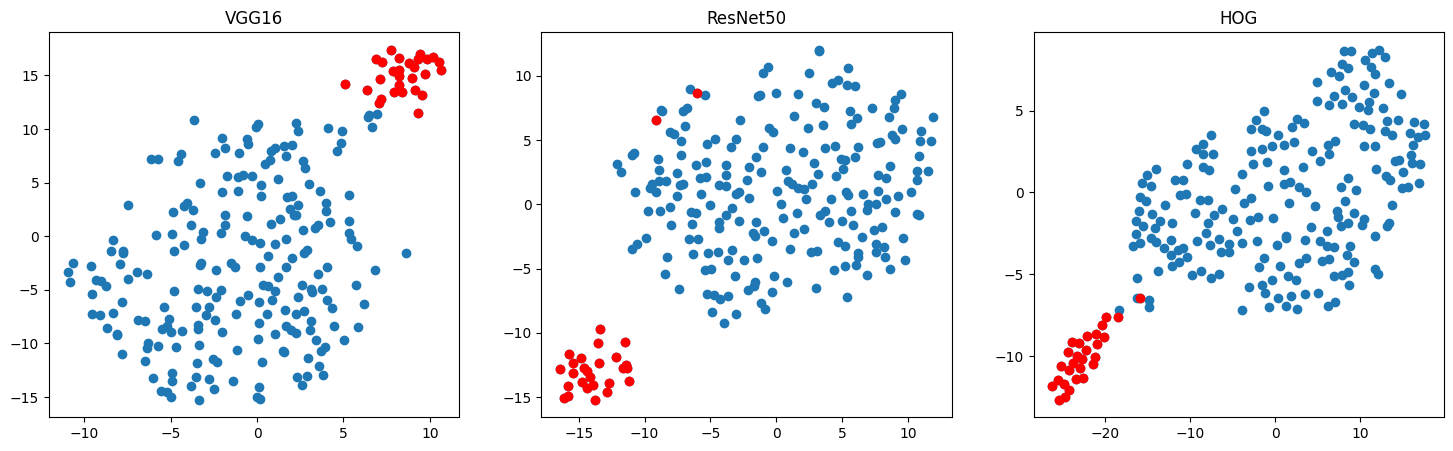

In [95]:

from matplotlib import pyplot as plt
plt.figure(figsize=(18,5))
plt.subplot(131)
plt.scatter(tsne_results_vgg[:, 0], tsne_results_vgg[:, 1])
plt.scatter(tsne_results_vgg[mask, 0], tsne_results_vgg[mask, 1], c="red")
plt.title("VGG16")
plt.subplot(132)
plt.scatter(tsne_results_resnet[:, 0], tsne_results_resnet[:, 1])
plt.scatter(tsne_results_resnet[mask, 0], tsne_results_resnet[mask, 1], c="red")
plt.title("ResNet50")
plt.subplot(133)
plt.scatter(tsne_results_hog[:, 0], tsne_results_hog[:, 1])
plt.scatter(tsne_results_hog[mask, 0], tsne_results_hog[mask, 1], c="red")
plt.title("HOG")
plt.show()


In [45]:
print(tsne_results.shape)
print(features.shape)
print(all_avgs.shape)
print(mask.shape)

import pandas as pd
import tifffile as tiff

import cv2


for i, avg in enumerate(all_avgs):
    filename = os.path.join("/Users/lorenz.lamm/PhD_projects/Napari/Surforama/rotational_averages", f"avg_{i}.tif")
    tiff.imsave(filename, avg)

# save tsne table
df = pd.DataFrame(tsne_results, columns=["x", "y"])
df.to_csv("/Users/lorenz.lamm/PhD_projects/Napari/Surforama/rotational_averages/tsne_results.csv")

# save features
df = pd.DataFrame(features)
df.to_csv("/Users/lorenz.lamm/PhD_projects/Napari/Surforama/rotational_averages/features_vgg.csv")

# save mask
df = pd.DataFrame(mask)
df.to_csv("/Users/lorenz.lamm/PhD_projects/Napari/Surforama/rotational_averages/outlier_mask.csv")

(241, 2)
(241, 512)
(241, 20, 21)
(241,)


/var/folders/dg/6_8w4kjn4cs8q9k22r4rzlvdnws93h/T/ipykernel_16766/4024589868.py:14: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(filename, avg)


(241, 2)


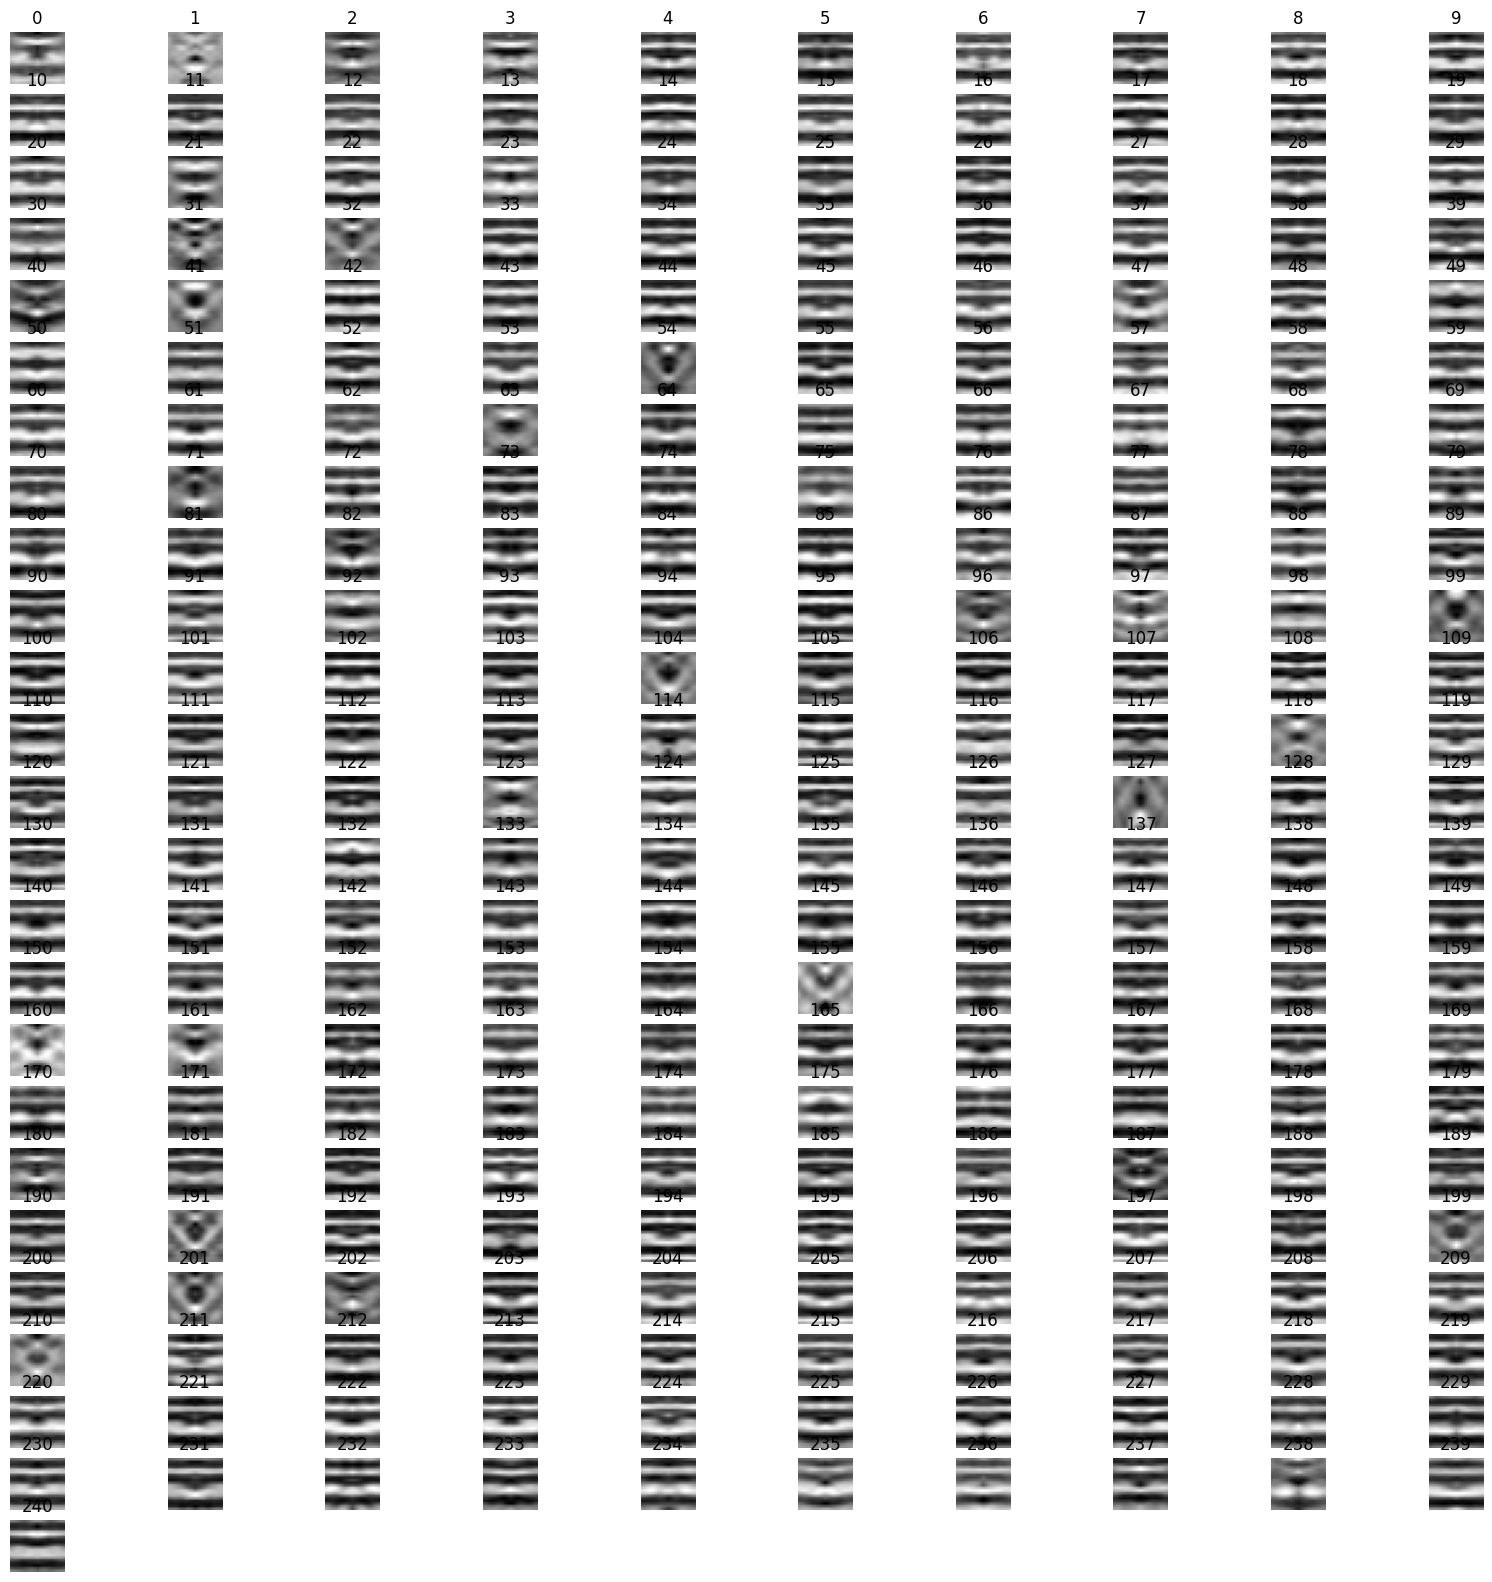

In [34]:
from matplotlib import pyplot as plt
plt.figure(figsize=(20, 20))
num_cols = 10
num_rows = all_avgs.shape[0] // num_cols + 1
for i, avg in enumerate(all_avgs):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(avg, cmap="gray")
    plt.title(i)
    plt.axis("off")
plt.show()

In [21]:
mask_idcs = [1, 21, 31, 32, 40, 41, 47, 54, 63, 71, 82, 96, 97, 99, 104, 118, 123, 127,155, 160, 161, 187, 199, 191, 201, 202, 210, 238]
mask = np.zeros(all_avgs.shape[0], dtype=bool)
mask[mask_idcs] = True


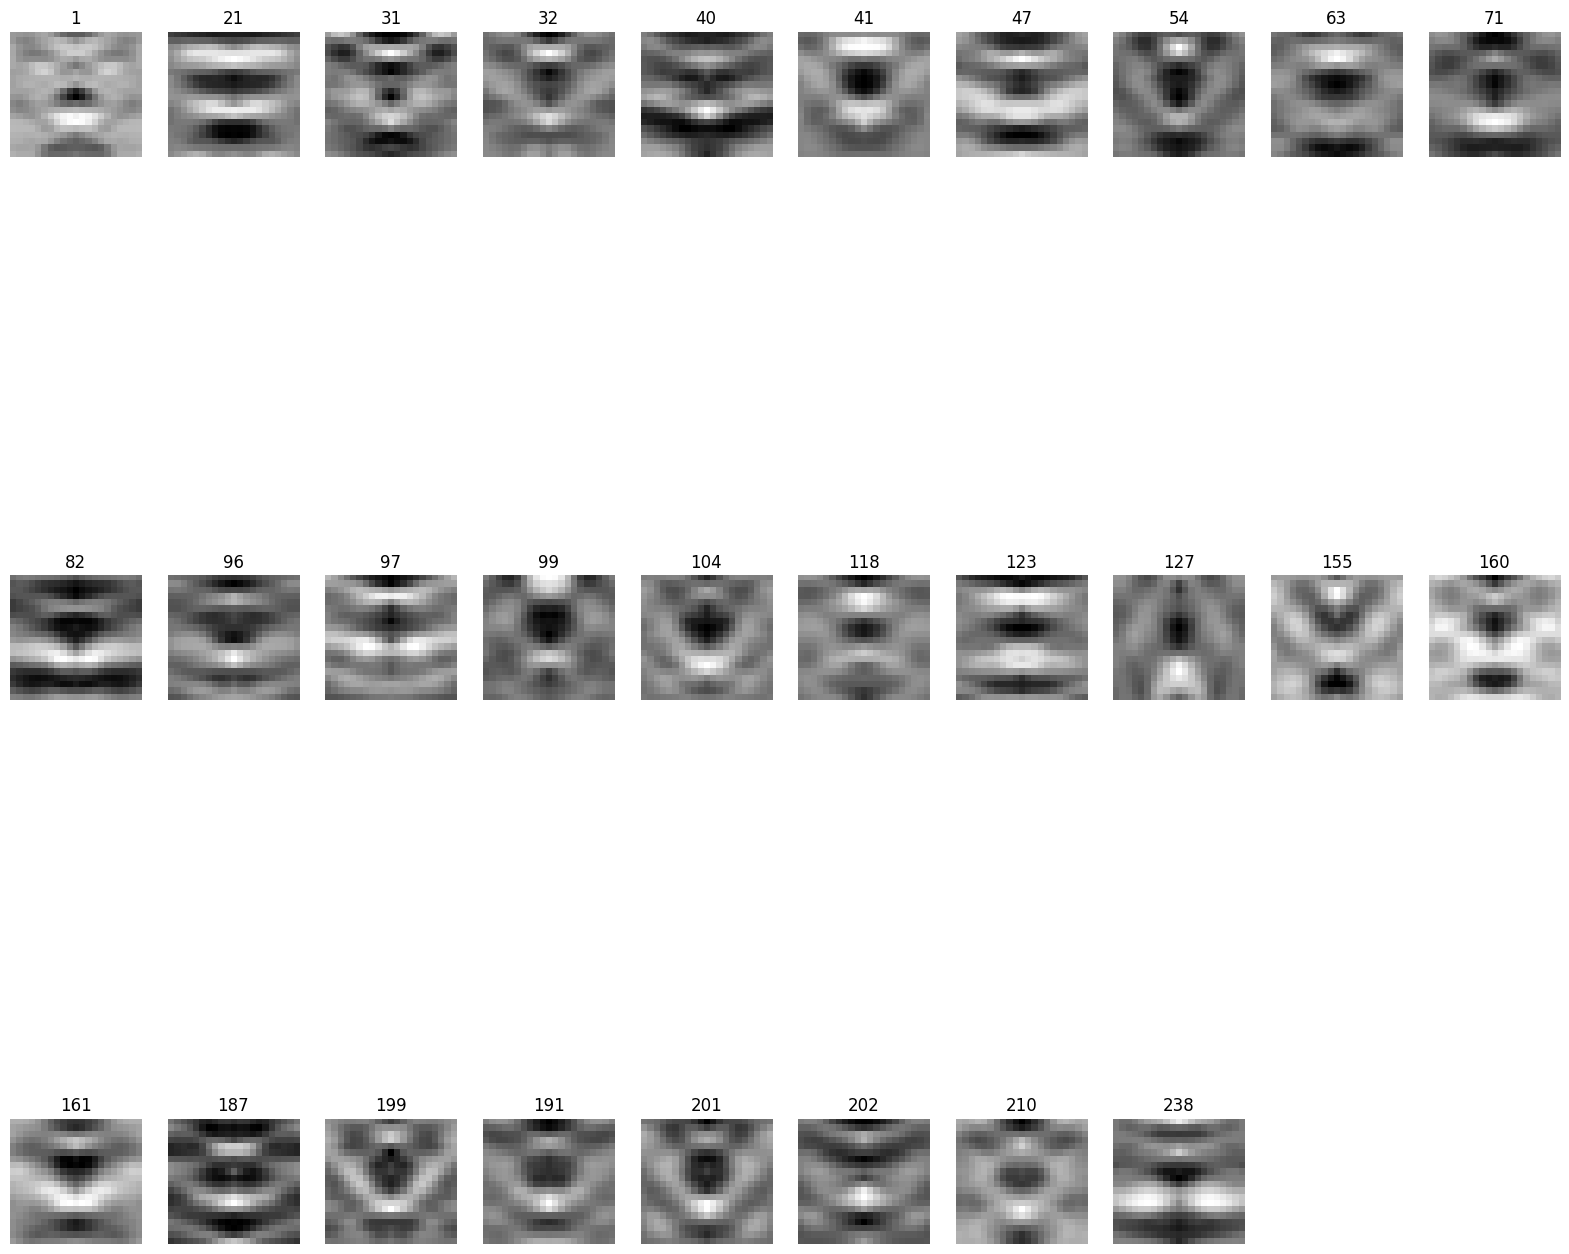

In [37]:
num_cols = 10
num_rows = mask.sum() // num_cols + 1
plt.figure(figsize=(20, 20))
for i, avg in enumerate(all_avgs[mask]):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(avg, cmap="gray")
    plt.title(mask_idcs[i])
    plt.axis("off")

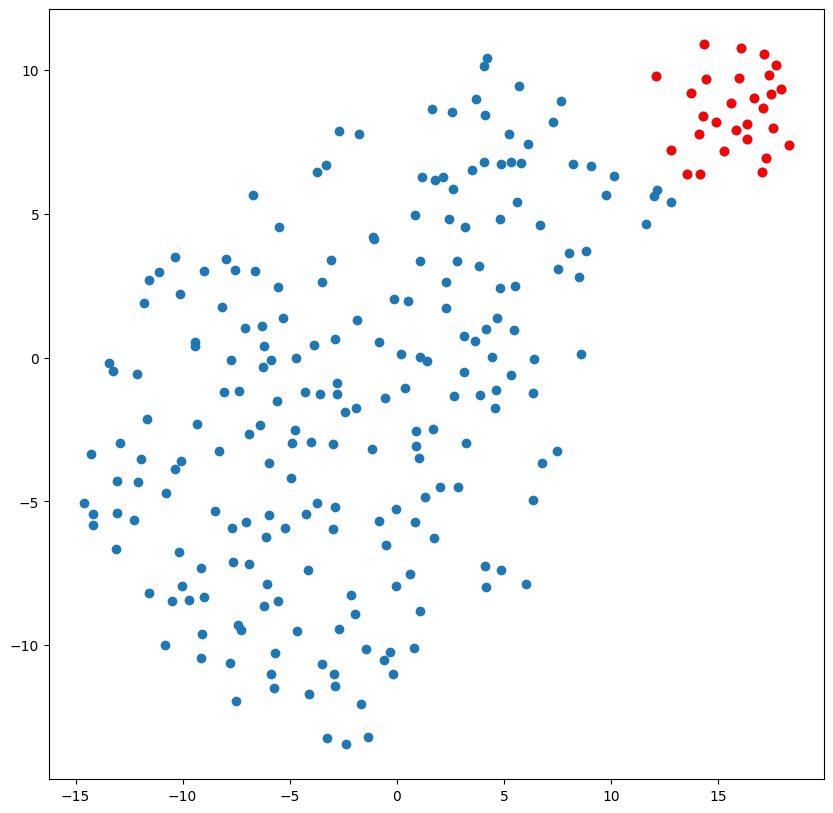

In [76]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10, 10))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1])
plt.scatter(tsne_results[mask, 0], tsne_results[mask, 1], c="red")
plt.show()

### Some example averages

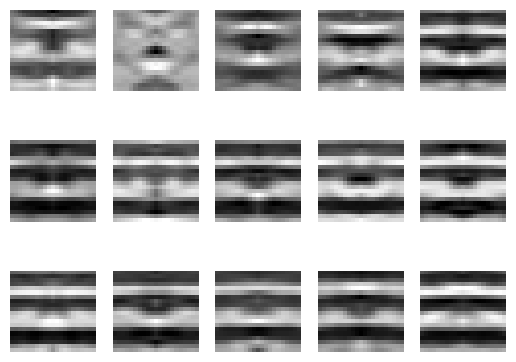

In [8]:
from matplotlib import pyplot as plt
num_example_averages = 15
plt.figure()
for i in range(num_example_averages):
    plt.subplot(3, 5, i+1)
    plt.imshow(np.concatenate((all_avgs[i, :, -1:0:-1], all_avgs[i]), axis=1), cmap='gray')
    plt.axis('off')
plt.show()

### Perform clustering with two different methods

In [15]:
from surforama.utils.twoD_averages import cluster_averages, get_2D_mask
# Define masks to focus cross-correlation on the center of the images
masks = [
    get_2D_mask(
        distance_top=6,
        distance_bottom=6,
        distance_side=0,
        shape=avg.shape
    ) for avg in all_avgs
]

labels_spectral = cluster_averages(all_avgs, masks, method="spectral_clustering")
labels_affinity = cluster_averages(all_avgs, masks, method="affinity_propagation")

### Look at cluster averages

In [25]:
def plot_class_averages(avgs, labels, mirror=False):
    plt.figure(figsize=(20, 20) )
    num_classer_per_row = 8
    num_classes = len(np.unique(labels))
    num_rows = int(np.ceil(num_classes / num_classer_per_row))
    for class_nr in np.unique(labels):
        avgs = np.array(avgs)
        class_avg = np.mean(avgs[labels == class_nr], axis=0)
        plt.subplot(num_rows, num_classer_per_row, class_nr + 1)
        if mirror:
            class_avg = np.concatenate((class_avg[:, -1:0:-1], class_avg), axis=1)
        plt.imshow(class_avg, cmap='gray')
        # plt.imshow(masks[0], cmap='gray', alpha=0.5)
        plt.axis('off')
        plt.title(f"Class {class_nr}")
    plt.show()

#### Class averages for spectral clustering

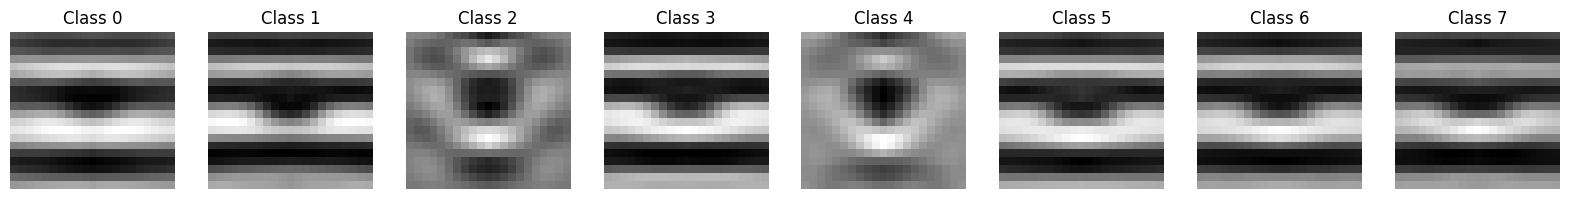

In [26]:
plot_class_averages(all_avgs, labels_spectral, mirror=True)

#### Class averages for Affinity Propagation

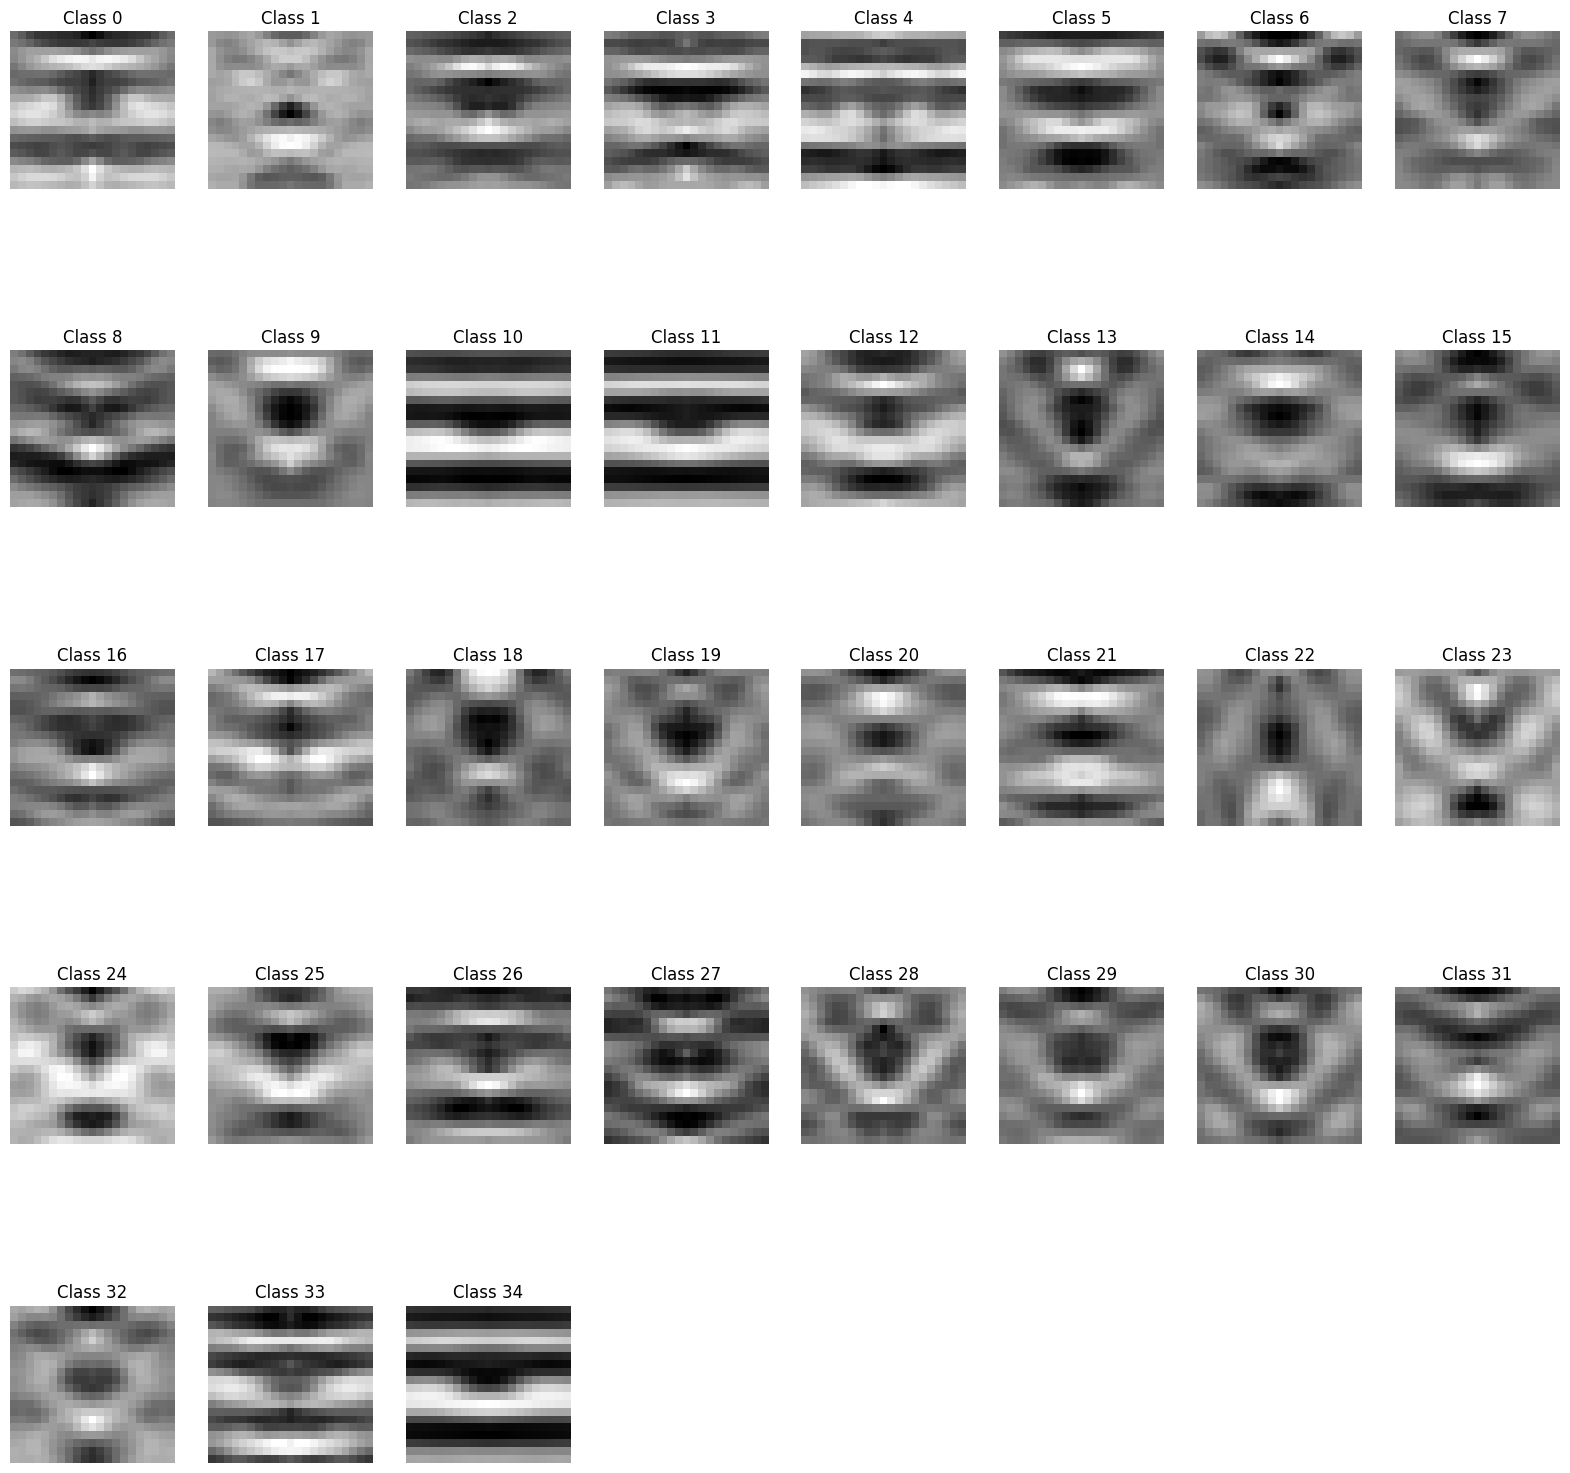

In [27]:
plot_class_averages(all_avgs, labels_affinity, mirror=True)

### Look at all class samples

In [29]:
from matplotlib import pyplot as plt

def plot_class(class_nr, avgs, labels, mirror=False):
    plt.figure(figsize=(20, 5))
    num_cols = 15
    num_elements = np.sum(labels == class_nr)
    num_rows = num_elements // num_cols + 1
    count = 0
    for i in range(len(labels)):
        if labels[i] != class_nr:
            continue
        count += 1
        plt.subplot(num_rows, num_cols, count)
        if mirror:
            plt.imshow(np.concatenate((avgs[i][:, -1:0:-1], avgs[i]), axis=1), cmap='gray')
        else:
            plt.imshow(avgs[i], cmap='gray')
        plt.axis('off')
    plt.show()

#### All class samples for spectral clustering

Class 0 for spectral clustering:


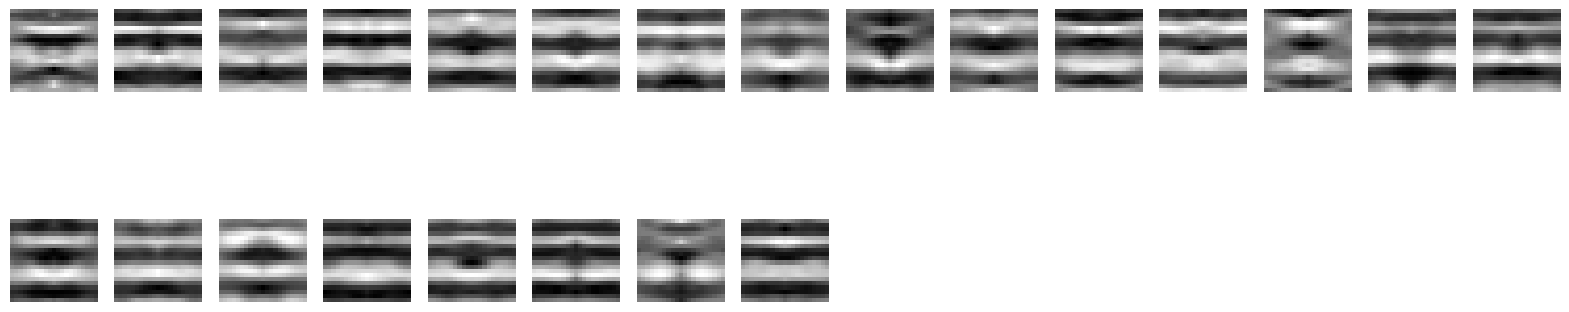

Class 1 for spectral clustering:


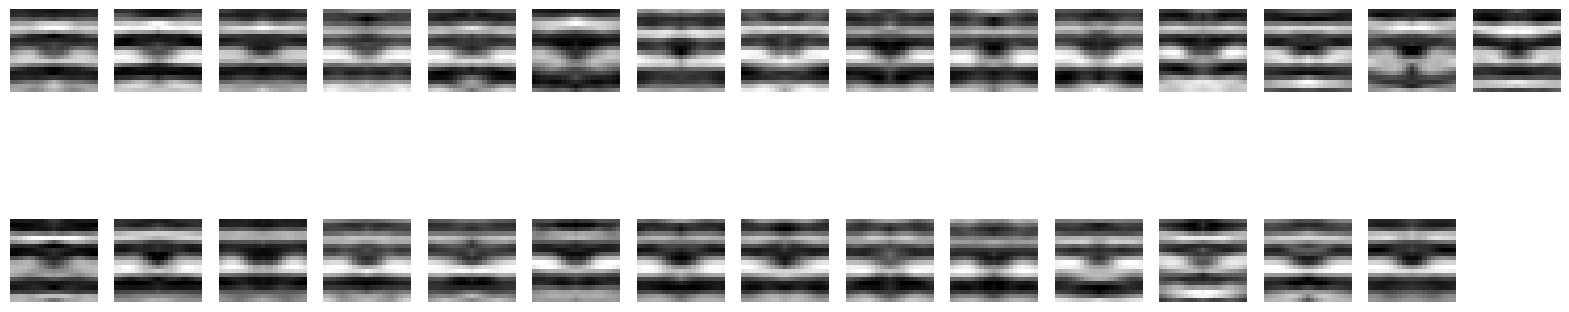

Class 2 for spectral clustering:


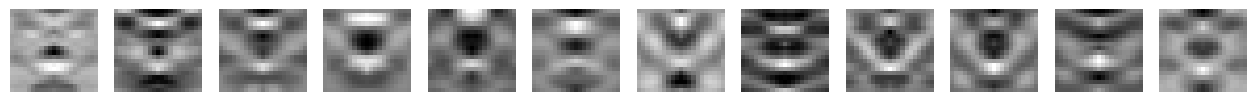

Class 3 for spectral clustering:


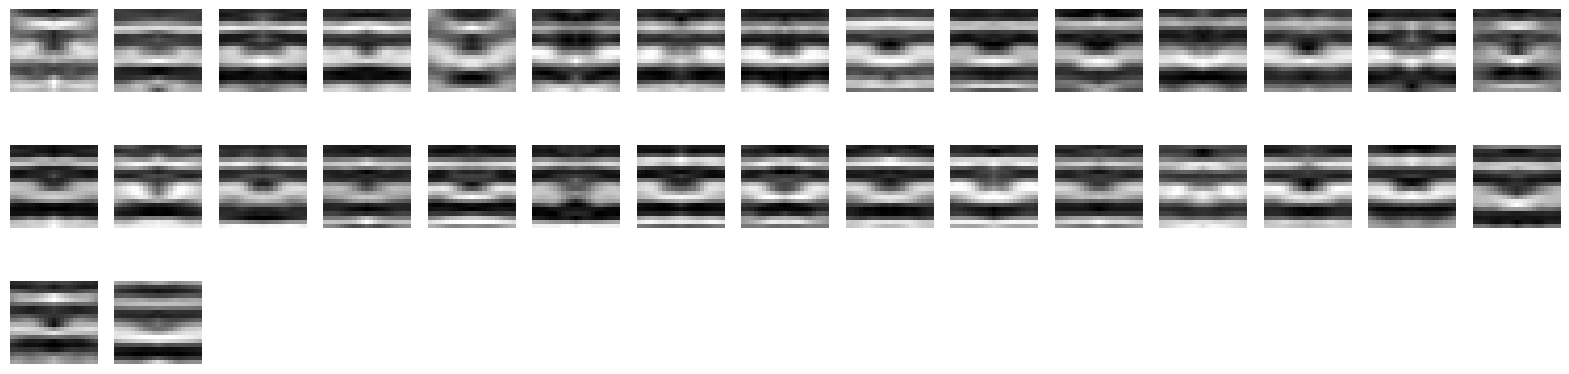

Class 4 for spectral clustering:


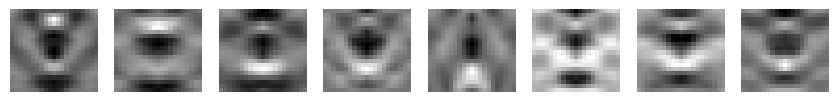

Class 5 for spectral clustering:


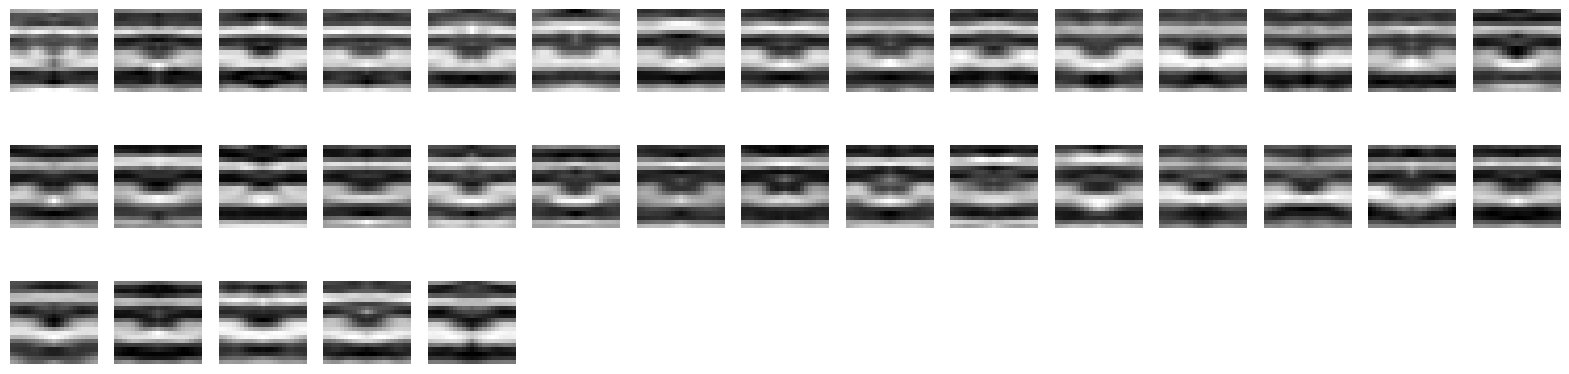

Class 6 for spectral clustering:


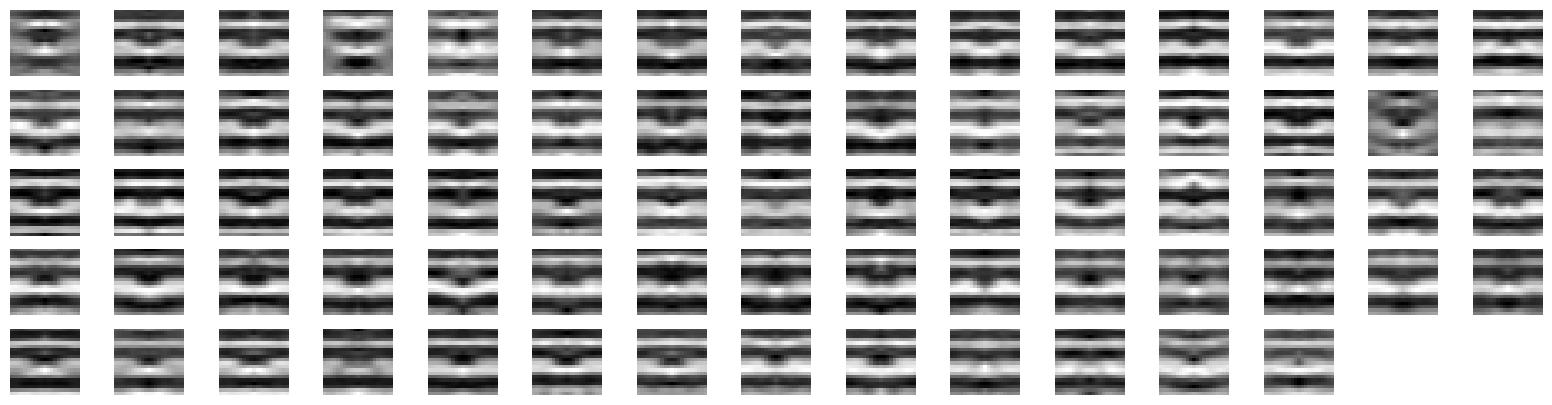

Class 7 for spectral clustering:


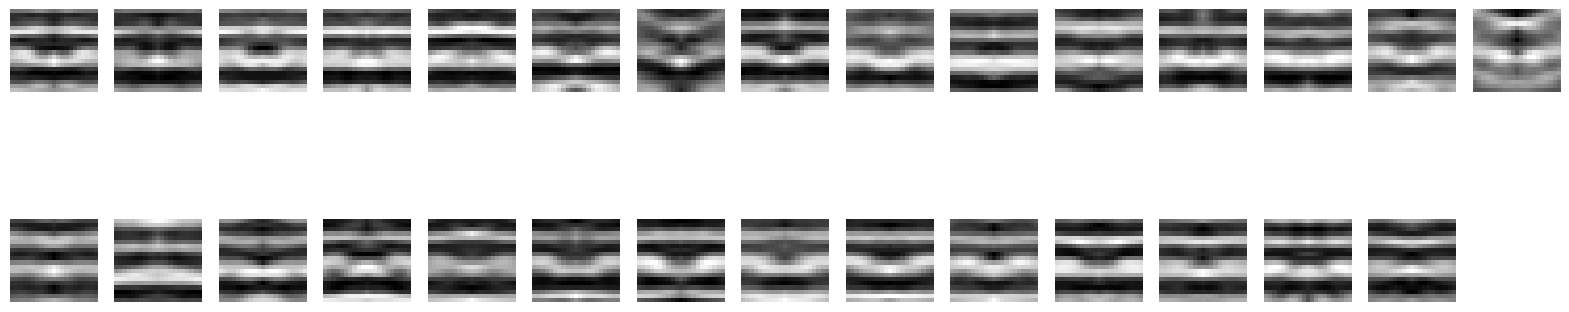

In [30]:
for class_nr in np.unique(labels_spectral):
    print(f"Class {class_nr} for spectral clustering:")
    plot_class(class_nr, all_avgs, labels_spectral, mirror=True)

#### All class samples for Affinity Propagation

Class 0 for affinity propagation:


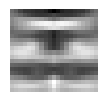

Class 1 for affinity propagation:


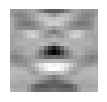

Class 2 for affinity propagation:


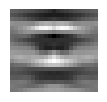

Class 3 for affinity propagation:


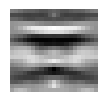

Class 4 for affinity propagation:


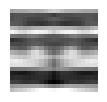

Class 5 for affinity propagation:


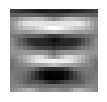

Class 6 for affinity propagation:


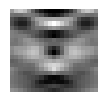

Class 7 for affinity propagation:


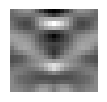

Class 8 for affinity propagation:


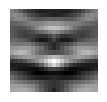

Class 9 for affinity propagation:


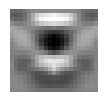

Class 10 for affinity propagation:


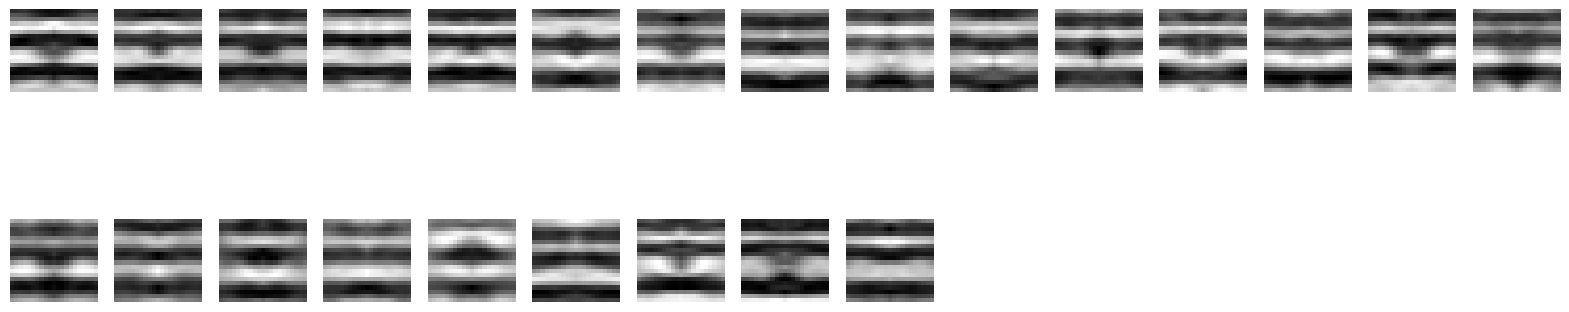

Class 11 for affinity propagation:


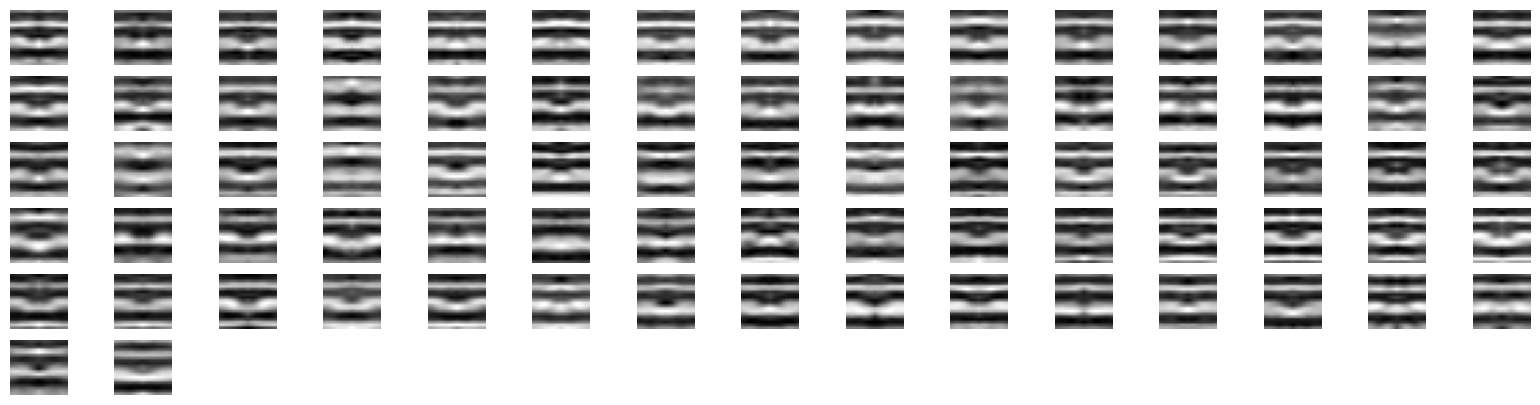

Class 12 for affinity propagation:


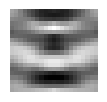

Class 13 for affinity propagation:


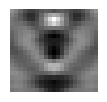

Class 14 for affinity propagation:


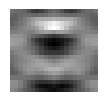

Class 15 for affinity propagation:


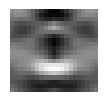

Class 16 for affinity propagation:


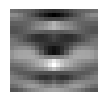

Class 17 for affinity propagation:


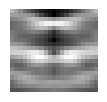

Class 18 for affinity propagation:


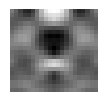

Class 19 for affinity propagation:


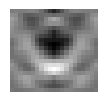

Class 20 for affinity propagation:


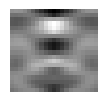

Class 21 for affinity propagation:


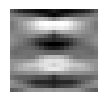

Class 22 for affinity propagation:


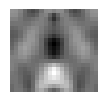

Class 23 for affinity propagation:


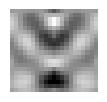

Class 24 for affinity propagation:


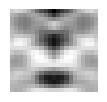

Class 25 for affinity propagation:


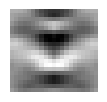

Class 26 for affinity propagation:


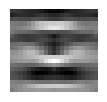

Class 27 for affinity propagation:


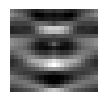

Class 28 for affinity propagation:


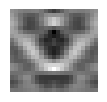

Class 29 for affinity propagation:


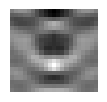

Class 30 for affinity propagation:


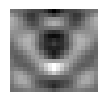

Class 31 for affinity propagation:


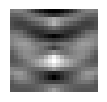

Class 32 for affinity propagation:


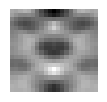

Class 33 for affinity propagation:


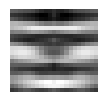

Class 34 for affinity propagation:


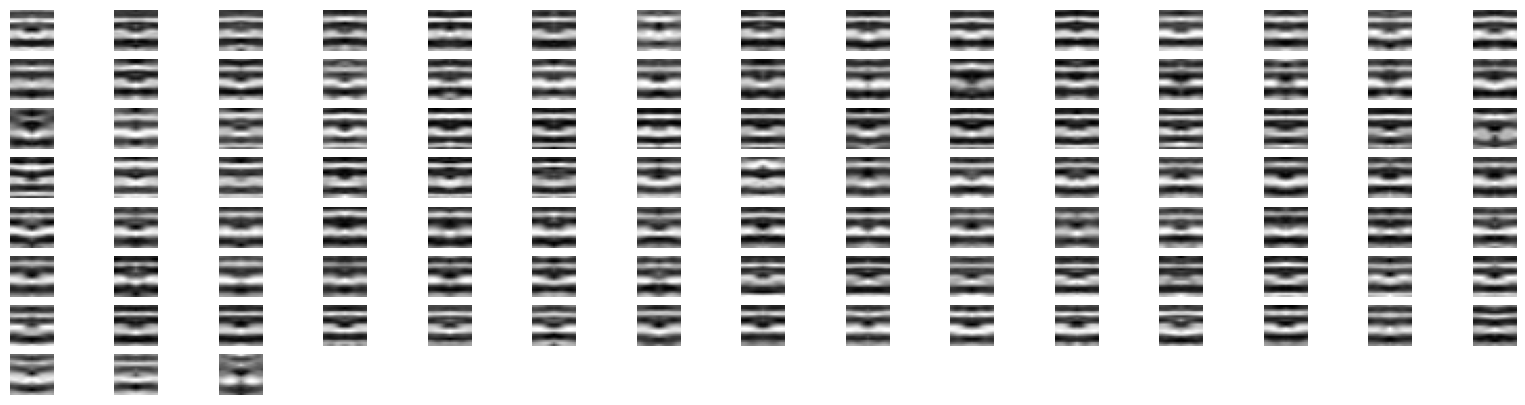

In [31]:
for class_nr in np.unique(labels_affinity):
    print(f"Class {class_nr} for affinity propagation:")
    plot_class(class_nr, all_avgs, labels_affinity, mirror=True)